In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
price_df = pd.read_csv("/Users/shurui/python/sparseDictionaryTimeSeries/Data/Dow Jones Industrial Average Historical Data - Daily.csv")
price = price_df[["Date", "Price"]]

In [73]:
def triplet_function(a, b, c, a_t, b_t, c_t):
    if a_t > b_t > c_t:
        return (a, b, c)
    elif a_t > c_t > b_t:
        return (a, c, b)
    elif b_t > a_t > c_t:
        return (b, a, c)
    elif b_t > c_t > a_t:
        return (b, c, a)
    elif c_t > b_t > a_t:
        return (c, b, a)
    elif c_t > a_t > b_t:
        return (c, a, b)
    else:
        return (a, b, c)
    
def uniform_symbol(triplet, x_min, x_max, K):
    diff = x_max - x_min
    a, b, c = triplet
    return (int((a-x_min)*K/diff), int((b-x_min)*K/diff), int((c-x_min)*K/diff))


class m_eSAX():
    def __init__(self, window_size, R, data, K) -> None:
        assert window_size%R == 0
        self.window_size = window_size
        self.R = R
        self.data = data.copy()
        self.c = int(window_size/R)
        self.K = np.power(2, K)

    def preprocess(self):
        length = len(self.data.index)
        self.data.columns = self.data.columns.map(lambda x: x.lower())
        self.data.loc[:, "price"] = self.data["price"].map(lambda x: x.replace(",", ""))
        self.data.loc[:, "price"] = self.data["price"].astype("float")

        self.start_time = self.data["date"][length-1]
        self.data["time"] = self.data.index[::-1]

    def add_window_group(self):
        length = len(self.data.index)
        window_num = int(length/self.window_size) + 1
        group_num = self.c + 1
        group = np.array([i for i in range(int(group_num*window_num))]).repeat(self.R)[:length]
        window = np.array([i for i in range(int(window_num))]).repeat(self.window_size)[:length]
        self.data.loc[:, "window"] = window
        self.data.loc[:, "group"] = group
        self.data.loc[:, "index"] = self.data.index

        return self.data
    
    def group_info(self):
        self.group_res = self.data.groupby(by="group").agg({"time": ["mean"], "price": ["mean", "min", "max"]})
        self.group_res["argmin"] = self.data.groupby('group')['price'].idxmin()
        self.group_res["argmax"] = self.data.groupby('group')['price'].idxmax()
        self.group_res.columns = ["time_mean", "mean", "min", "max", "argmin", "argmax"]

        self.group_res = self.group_res.merge(self.data[["index", "time"]], how="left", left_on="argmin", right_on="index")
        self.group_res = self.group_res.merge(self.data[["index", "time"]], how="left", left_on="argmax", right_on="index", suffixes=["_min", "_max"])
        self.group_res = self.group_res.drop(columns=["index_min", "index_max", "argmin", "argmax"])

    def group_triplet(self):
        self.group_res["triplet"] = self.group_res.apply(lambda x: triplet_function(
            x["mean"], x["min"], x["max"], x["time_mean"], x["time_min"], x["time_max"]
        ), axis=1)

    def get_triplet(self):
        self.preprocess()
        self.add_window_group()
        self.group_info()
        self.group_triplet()

    def uniform_breakpoint(self):
        x_min = self.data["price"].min()
        x_max = self.data["price"].max()
        self.group_res["uniform_symbol"] = self.group_res.apply(lambda x: uniform_symbol(
            x["triplet"], x_min, x_max, self.K
        ), axis=1)
    

In [74]:
window_size = 50
R = 10
K = 5
model = m_eSAX(window_size, R, price, K)
model.get_triplet()

In [75]:
model.group_res

,time_mean,mean,min,max,time_min,time_max,triplet
0,1253.5,37464.788,37082.39,37710.63,1252,1257,"(37710.63, 37464.788, 37082.39)"
1,1243.5,36431.609,36054.43,37248.28,1242,1248,"(37248.28, 36431.609000000004, 36054.43)"
2,1233.5,35292.73,34945.6,35950.96,1229,1238,"(35950.96, 35292.73, 34945.6)"
3,1223.5,34259.325,33839.11,34991.21,1219,1228,"(34991.21, 34259.325, 33839.11)"
4,1213.5,33011.275,32418.05,33413.45,1215,1209,"(32418.05, 33011.275, 33413.45)"
...,...,...,...,...,...,...,...
121,43.5,25735.623,25450.24,26026.32,46,41,"(25450.24, 25735.623, 26026.32)"
122,33.5,25816.98,25425.76,26091.95,29,37,"(26091.95, 25816.980000000003, 25425.76)"
123,23.5,25102.854,24579.96,25411.52,19,24,"(25411.52, 25102.853999999996, 24579.96)"
124,13.5,24405.78,23909.84,24737.2,9,17,"(24737.2, 24405.78, 23909.84)"


In [54]:
model = m_eSAX(window_size, R, price, K)
model.preprocess()
price_add = model.add_window_group()
model.group_info()
model.group_triplet()
model.uniform_breakpoint()
group_res = model.group_res

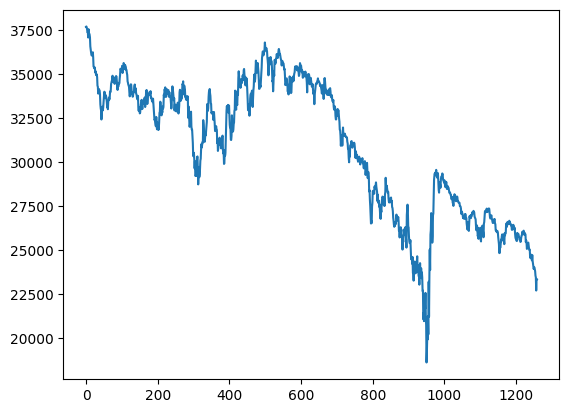

In [55]:
time_series = np.array(model.data["price"])
plt.plot(time_series)

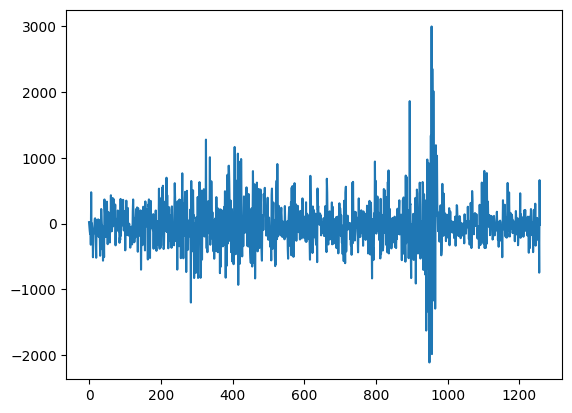

In [56]:
time_series_diff = np.diff(np.array(model.data["price"]))
plt.plot(time_series_diff)

In [80]:
time_series.shape

(1259,)

In [92]:
def create_sliding_windows(data, window_size, stride):
    num_samples = len(data)
    num_windows = ((num_samples - window_size) // stride) + 1
    X_matrix_m = []
    X_matrix_p = []
    y_label = np.ones(num_windows) - 1

    for i in range(num_windows-1):
        start = i * stride
        end = start + window_size
        window = data[start:end]
        if data[end] >= window[-1]:
            X_matrix_p.append(window.T)
        else:
            X_matrix_m.append(window.T)

    return np.array(X_matrix_p), np.array(X_matrix_m)

In [94]:
X_ts_p, X_ts_m = create_sliding_windows(time_series, 30, 1)
X_ts_m.shape

(664, 30)

In [57]:
def create_sliding_windows(data, window_size, stride):
    num_samples = len(data)
    num_windows = ((num_samples - window_size) // stride) + 1
    X_matrix = np.zeros((num_windows, window_size))

    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        window = data[start:end]
        X_matrix[i, :] = window.T

    return X_matrix

In [58]:
X_ts = create_sliding_windows(time_series, 30, 2)
X_ts.shape

(615, 30)

In [59]:
X_ts_diff = create_sliding_windows(time_series_diff, 30, 2)
X_ts_diff.shape

(615, 30)

In [47]:
class alternated_resolution():
    
    def __init__(self, time_series, K, K0, feature_num) -> None:
        self.X = time_series
        self.K = K
        self.K0 = K0
        self.feature_num = feature_num
        self.D = np.random.randn(self.X.shape[0], K)

    def projection(self, z):
        res = z.copy()
        sort = np.sort(res, axis=1)[:, -self.K0]
        res = np.where(res - sort[:,np.newaxis]>=0, res, 0)
        return res
    
    def projection_D(self, y=None):
        if y is None:
            norm = np.linalg.norm(self.D, axis=0)
            norm = np.where(norm > 1, norm**2, 1)
            self.D = self.D/norm
            return self.D
        else:
            norm = np.linalg.norm(y, axis=0)
            norm = np.where(norm > 1, norm**2, 1)
            y = y/norm
            return y

    def sparse_coding(self, tol, max_iter):
        L = np.sort(np.linalg.eigvalsh(np.matmul(self.D.T, self.D)))[-1]
        step_size = 1 / L
        z = np.zeros((self.K, self.X.shape[1]))
        z[0: self.K0] = 1
        z_next = z
        z_change = 1
        count = 0
        while z_change > tol and count < max_iter:
            z = z_next
            count += 1
            z = z - step_size * np.matmul(self.D.T, np.matmul(self.D, z) - self.X)
            z_next = self.projection(z)
            z_change = np.max(np.abs(z_next - z))
        return z_next
    
    def dictionary_learning(self, tol, max_iter, z):
        L = np.sort(np.linalg.eigvalsh(np.matmul(z, z.T)))[-1]
        step_size = 1 / L
        D_change = 1
        D_next = self.D
        count = 0
        while D_change > tol and count < max_iter:
            self.D = D_next
            count += 1
            self.D = self.D - step_size * (np.matmul(np.matmul(self.D, z) - self.X, z.T))
            D_next = self.projection_D()
            D_change = np.max(np.abs(D_next - self.D))
        return self.D 
    
    def alternated_resolution(self, tol, max_iter, iter):
        for i in range(iter):
            Z = self.sparse_coding(tol, max_iter)
            self.dictionary_learning(tol, max_iter, Z)
        return self.D, Z


In [48]:
model1 = alternated_resolution(X_ts, 150, 15, 30)
_, Z1 = model1.alternated_resolution(1e-6, 50000, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [49]:
X_re1 = model1.D.dot(Z1)
np.linalg.norm(X_re1-model1.X, ord='fro')

386552.6593677585

In [245]:
model = alternated_resolution(X_ts, 150, 15, 30)
_, Z = model.alternated_resolution(1e-6, 50000, 100)

In [277]:
X_re = model.D.dot(Z)
X_re

array([[38019.25898626, 38000.86586826, 37888.71018901, ...,
        35359.50820272, 35732.21669052, 35560.48060363],
       [37465.24453429, 37464.17512158, 37420.17548748, ...,
        35465.09839095, 35398.85114363, 35517.09250881],
       [37553.76517577, 37362.75035404, 37413.09096569, ...,
        35094.19632526, 35497.74072832, 35642.64830215],
       ...,
       [26051.3852425 , 25987.89823006, 26030.65878753, ...,
        24564.7251228 , 24350.18401075, 24181.13712431],
       [25378.12163725, 25258.78427162, 25270.55808589, ...,
        24258.33507748, 23982.95593498, 23749.21191694],
       [25350.5101253 , 25514.81274382, 25214.86980645, ...,
        23557.10907964, 23512.02608989, 23483.23940597]])

In [278]:
np.linalg.norm(X_re-model.X, ord='fro')

63451.36052098787

In [28]:
class KSVD():
    def __init__(self, time_series, K=256, K0=None):
        self.D = None
        self.K = K
        self.K0 = K0
        self.time_series = time_series
        self.num = time_series.shape[0]
    
    def initialize(self):

        shape=[self.num, self.K]
        self.D = np.random.random(shape)
        for i in range(shape[1]):
            self.D[:, i]=self.D[:, i]/np.linalg.norm(self.D[:, i])

    def update_dict(self, sparse_code):

        for i in range(self.K):
            index = np.nonzero(sparse_code[i, :])[0]
            if len(index) == 0:
                continue
            self.D[:, i] = 0
            r = (self.time_series - np.dot(self.D, sparse_code))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            self.D[:, i] = u[:, 0].T
            sparse_code[i, index] = s[0] * v[0, :]
        return self.D, sparse_code
    
    def projection(self, z):
        res = z.copy()
        sort = np.sort(res, axis=1)[:, -self.K0]
        res = np.where(res - sort[:,np.newaxis]>=0, res, 0)
        return res

    def sparse_coding(self, tol, max_iter):
        L = np.sort(np.linalg.eigvalsh(np.matmul(self.D.T, self.D)))[-1]
        step_size = 1 / L
        sparse_code = np.zeros((self.K, self.time_series.shape[1]))
        sparse_code[0: self.K0] = 1
        sparse_code_next = sparse_code
        sparse_code_change = 1
        count = 0
        while sparse_code_change > tol and count < max_iter:
            sparse_code = sparse_code_next
            count += 1
            sparse_code = sparse_code - step_size * np.matmul(self.D.T, np.matmul(self.D, sparse_code) - self.time_series)
            sparse_code_next = self.projection(sparse_code)
            sparse_code_change = np.max(np.abs(sparse_code_next - sparse_code))
        return sparse_code_next
    
    def ksvd(self, max_iter):
        self.initialize()
        for i in range(max_iter):
            sparse_code = self.sparse_coding(1e-5, 1000)
            dictionary, sparse_code = self.update_dict(sparse_code)
        return dictionary, sparse_code

In [60]:
model = KSVD(X_ts_diff, K=150, K0=15)
_, code = model.ksvd(100)

In [61]:
xre = model.D.dot(code)

In [70]:
xre[0]

array([  18.95327877,  -51.73113642, -113.09431732, -152.75265058,
         19.95034423, -325.00297248,  476.71011564, -256.51145359,
          6.77813649,  -56.04438967, -149.66857259, -513.37206677,
       -184.4120886 , -155.89257936, -125.96205086,  -65.44900732,
         70.73163585,   77.06228979,   38.519941  , -301.39690332,
       -519.97818026,  -15.42889097,  -83.33557684,   55.3200628 ,
       -114.98579722, -183.3433291 ,   65.23416644, -207.32686692,
          7.5660834 ,   43.79226771])

In [71]:
model.time_series[0]

array([  21.09,  -54.11, -111.19, -159.36,   18.38, -321.96,  475.59,
       -252.03,    3.27,  -60.94, -157.45, -512.89, -173.14, -157.06,
       -130.17,  -63.14,   70.13,   79.88,   41.06, -294.54, -520.41,
        -13.64,  -83.51,   57.17, -117.8 , -184.48,   62.68, -203.69,
         -1.68,   45.61])

In [67]:
np.linalg.norm(xre-model.time_series, ord='fro')

503.16244005579

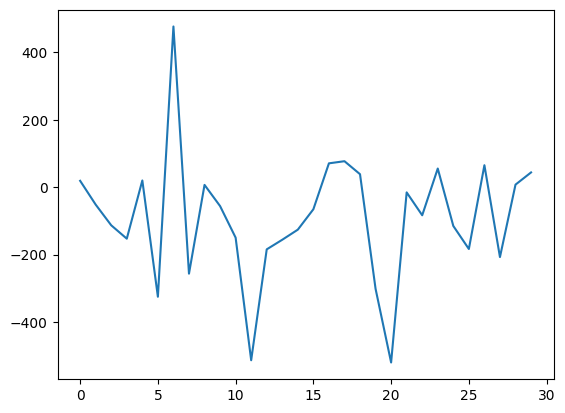

In [65]:
plt.plot(xre[0])

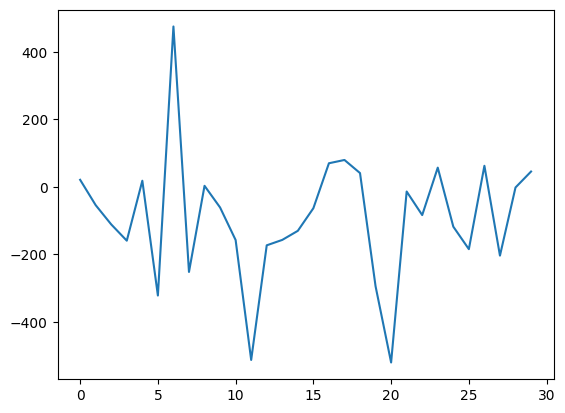

In [66]:
plt.plot(model.time_series[0])

In [29]:
X_ts.shape

(615, 30)

In [30]:
model = KSVD(X_ts, K=150, K0=15)

In [31]:
_, code = model.ksvd(100)

In [33]:
code.shape

(150, 30)

In [34]:
xre = model.D.dot(code)

In [36]:
np.linalg.norm(xre-model.time_series, ord='fro')

33524.27800385724

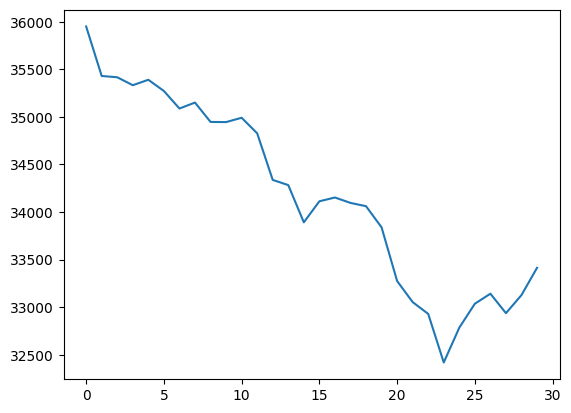

In [41]:
plt.plot(model.time_series[10])

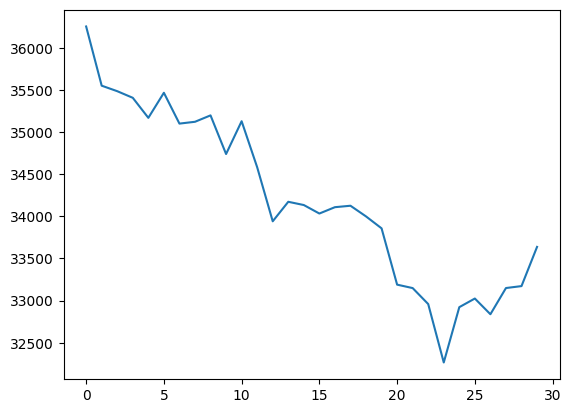

In [42]:
plt.plot(xre[10])